In [2]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o

## Result Gathering

In [3]:
main_df = None
directory = "Effort_Estimation_Results_v5_SmallProjectsSize/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Cxf.csv
Dbeaver.csv
Okhttp.csv
Redisson.csv


In [4]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,num_line_affected_min,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken
0,3,19.225678,1.0,167.0,1.0,2.0,2.0,3.0,4.0,7.0,...,24,1245,682.248,35.0,1,54,29.512709,2162,0.011101,1.0
1,3,19.225678,1.0,167.0,1.0,2.0,2.0,3.0,4.0,7.0,...,242,242,0.000,4.0,4,4,0.000000,142,1.000000,1.0
2,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,61,61,NaN,2.0,2,2,NaN,8,1.000000,15.0
3,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,78,78,NaN,1.0,1,1,NaN,346,0.225434,1.0
4,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,322,322,0.000,1.5,1,2,0.707107,35,1.000000,1.0


In [5]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [6]:
len(main_df)

200

In [7]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue', label='y_test')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='y_pred')
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

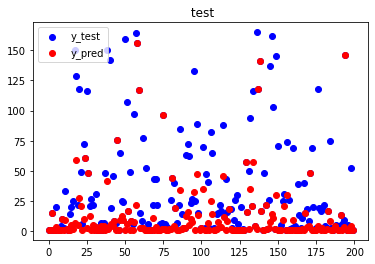

In [8]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],' test')

In [9]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [10]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



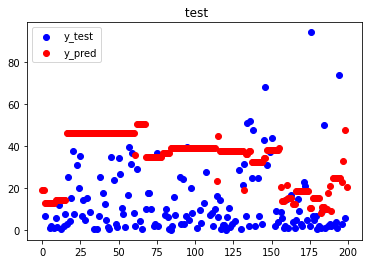

In [11]:
plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x209c22c5cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x209c22d4390>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c22c5b70>],
 'medians': [<matplotlib.lines.Line2D at 0x209c22d4a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x209c22d4e10>],
 'means': []}

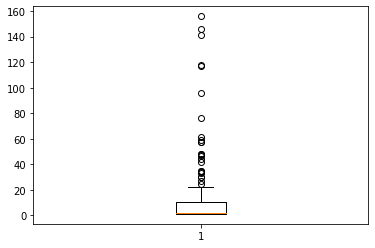

In [12]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [13]:
main_df = main_df[main_df['refactoring_perc_time_taken'] >= 2]
main_df = main_df[main_df['refactoring_perc_time_taken'] <= 40]

{'whiskers': [<matplotlib.lines.Line2D at 0x209c2337c88>,
 'caps': [<matplotlib.lines.Line2D at 0x209c2346358>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c2337b38>],
 'medians': [<matplotlib.lines.Line2D at 0x209c2346a58>],
 'fliers': [<matplotlib.lines.Line2D at 0x209c2346dd8>],
 'means': []}

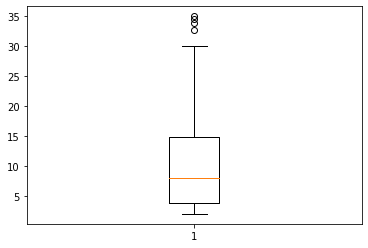

In [14]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [15]:
main_df = main_df[main_df['time_taken_final'] <= 60]
main_df = main_df[main_df['time_taken_final'] > 2]

In [16]:
main_df['time_taken_final'].value_counts()

7.0     5
3.0     5
9.0     3
2.8     2
6.0     2
8.0     2
31.0    2
8.2     2
39.6    2
15.4    2
2.4     1
16.6    1
8.4     1
43.0    1
31.4    1
10.4    1
13.0    1
16.0    1
10.0    1
18.0    1
4.0     1
24.0    1
5.0     1
8.6     1
12.0    1
35.6    1
24.6    1
37.1    1
25.6    1
26.6    1
6.2     1
12.4    1
2.6     1
10.2    1
6.2     1
14.4    1
25.6    1
37.6    1
50.0    1
8.8     1
3.6     1
17.6    1
29.4    1
15.0    1
27.6    1
Name: time_taken_final, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x209c23ac0f0>,
 'caps': [<matplotlib.lines.Line2D at 0x209c23ac7b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c239ef60>],
 'medians': [<matplotlib.lines.Line2D at 0x209c23aceb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x209c23b4278>],
 'means': []}

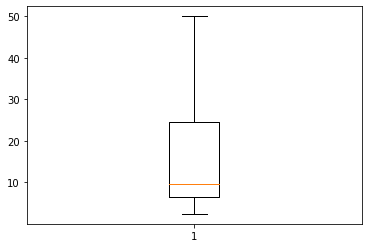

In [17]:
plt.boxplot(main_df['time_taken_final'])

In [18]:
main_df = main_df.fillna(0)

In [19]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,time_taken_final
2,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,61,0.000000,2.000000,2,2,0.000000,8,1.000000,15.000000,7.0
9,10,14.581832,1.0,152.0,1.0,1.2,2.0,2.0,4.0,6.0,...,764,0.000000,9.000000,9,9,0.000000,202,1.000000,10.000000,6.0
11,10,14.581832,1.0,152.0,1.0,1.2,2.0,2.0,4.0,6.0,...,115,0.000000,4.500000,3,6,2.121320,400,0.287500,9.487500,12.0
15,10,14.581832,1.0,152.0,1.0,1.2,2.0,2.0,4.0,6.0,...,47,0.000000,9.333333,1,14,7.234178,176,0.267045,5.340909,8.0
0,1,46.327198,1.0,167.0,2.0,6.6,11.0,16.0,22.2,28.0,...,175,78.488853,68.500000,59,78,13.435029,780,0.082051,2.051282,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1,15.567240,1.0,163.0,1.0,2.0,2.0,3.0,4.0,8.0,...,15,0.000000,1.000000,1,1,0.000000,114,0.131579,2.500000,7.0
8,5,11.102628,1.0,167.0,1.0,1.0,2.0,2.0,3.0,4.0,...,67,9.192388,1.500000,1,2,0.707107,12,1.000000,17.000000,9.0
9,5,11.102628,1.0,167.0,1.0,1.0,2.0,2.0,3.0,4.0,...,20,0.000000,24.000000,24,24,0.000000,185,0.108108,8.108108,50.0
1,6,24.722772,1.0,148.0,2.0,3.0,4.0,6.0,10.4,14.0,...,907,362.783108,5.000000,2,8,2.581989,55,1.000000,13.000000,2.6


In [20]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [21]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [22]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [23]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [24]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [25]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken')
Y_col = ['refactoring_perc_time_taken']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [26]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
2,11.0,11,11,0.00000,8.0,8,8,0.000000,2.0,2,...,58.0,58,58,0.00000,17.0,17,17,0.0,85.0,61.0
9,38.0,38,38,0.00000,57.0,57,57,0.000000,1.0,1,...,279.0,279,279,0.00000,17.0,17,17,0.0,322.0,764.0
11,4.0,4,4,0.00000,15.0,15,15,0.000000,1.0,1,...,108.0,108,108,0.00000,1.0,1,1,0.0,371.0,115.0
15,3.0,3,3,0.00000,5.0,5,5,0.000000,1.0,1,...,38.0,38,38,0.00000,16.0,16,16,0.0,23.0,47.0
0,21.5,20,23,2.12132,9.0,6,12,4.242641,3.0,3,...,68.0,54,82,19.79899,0.0,0,0,0.0,12.5,119.5


In [27]:
y.head()

,refactoring_perc_time_taken
2,15.000000
9,10.000000
11,9.487500
15,5.340909
0,2.051282


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

In [29]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\tanji\AppData\Local\Temp\tmppaj_rcmw
  JVM stdout: C:\Users\tanji\AppData\Local\Temp\tmppaj_rcmw\h2o_tanji_started_from_python.out
  JVM stderr: C:\Users\tanji\AppData\Local\Temp\tmppaj_rcmw\h2o_tanji_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,3 months and 17 days !!!
H2O_cluster_name:,H2O_from_python_tanji_1m25f6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.984 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [30]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.7])


x = train.columns
y = "refactoring_perc_time_taken"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [31]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [32]:
train[y].types

{'refactoring_perc_time_taken': 'real'}

In [33]:
aml = H2OAutoML(max_models=10, seed=16, exclude_algos=['XGBoost', 'GLM'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |██████
11:18:44.96: Skipping training of model GBM_5_AutoML_20211220_111837 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20211220_111837.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 44.0.


██████████████████████████████████████████████████| 100%


In [34]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_lr_annealing_selection__AutoML_20211220_111837_select_model,90.0712,9.49058,90.0712,7.54749,0.749397
XRT_1_AutoML_20211220_111837,95.7773,9.78659,95.7773,7.63526,0.770758
GBM_3_AutoML_20211220_111837,96.3257,9.81456,96.3257,7.58449,0.789363
GBM_4_AutoML_20211220_111837,98.0516,9.9021,98.0516,7.73243,0.794646
DRF_1_AutoML_20211220_111837,99.6517,9.98257,99.6517,7.63898,0.78874
StackedEnsemble_BestOfFamily_AutoML_20211220_111837,100.054,10.0027,100.054,7.80237,0.779398
GBM_2_AutoML_20211220_111837,100.186,10.0093,100.186,7.79201,0.803436
GBM_grid__1_AutoML_20211220_111837_model_2,107.761,10.3808,107.761,8.09027,0.820101
GBM_1_AutoML_20211220_111837,110.991,10.5352,110.991,8.39108,0.839463
StackedEnsemble_AllModels_AutoML_20211220_111837,147.47,12.1437,147.47,8.58246,0.786185


In [35]:
model = h2o.get_model(lb[0,'model_id'])

In [36]:
model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_lr_annealing_selection__AutoML_20211220_111837_select_model


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,2510.0,1.0,1.0,1.0,2.0,2.0,2.0




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 45.28386400726676
RMSE: 6.729328644617289
MAE: 5.448880894617601
RMSLE: 0.5885420681688873
Mean Residual Deviance: 45.28386400726676

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 90.07117786979711
RMSE: 9.490583642210689
MAE: 7.547491119524178
RMSLE: 0.7493966108920483
Mean Residual Deviance: 90.07117786979711

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,7.564895,2.4184859,10.867628,7.8209376,6.5173817,4.2878547,8.330674
1,mean_residual_deviance,90.064575,54.633476,176.74368,96.2594,50.904064,36.641804,89.77391
2,mse,90.064575,54.633476,176.74368,96.2594,50.904064,36.641804,89.77391
3,r2,-0.9621036,1.3836206,-0.63424635,-0.5291592,-3.3900273,-0.32631916,0.06923398
4,residual_deviance,90.064575,54.633476,176.74368,96.2594,50.904064,36.641804,89.77391
5,rmse,9.15371,2.8004825,13.294498,9.811188,7.1347084,6.0532475,9.47491
6,rmsle,0.7463721,0.09034305,0.75845295,0.64205587,0.85529536,0.66868794,0.80736834



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-12-20 11:20:02,0.161 sec,0.0,9.082922,7.329089,82.499464
1,,2021-12-20 11:20:02,0.169 sec,5.0,8.174594,6.461760,66.823988
2,,2021-12-20 11:20:02,0.175 sec,10.0,7.673375,6.097476,58.880688
3,,2021-12-20 11:20:02,0.183 sec,15.0,7.346969,5.849302,53.977954
4,,2021-12-20 11:20:02,0.189 sec,20.0,7.118640,5.711871,50.675029
5,,2021-12-20 11:20:02,0.195 sec,25.0,6.920556,5.588125,47.894096
6,,2021-12-20 11:20:02,0.202 sec,30.0,6.729329,5.448881,45.283864



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,assignmentsQty_max,2475.586670,1.000000,0.265881
1,lcom_max,1656.153564,0.668994,0.177873
2,loc_min,1108.922729,0.447943,0.119100
3,uniqueWordsQty_min,990.387268,0.400062,0.106369
4,variablesQty_max,893.709045,0.361009,0.095985
5,lambdasQty_max,887.149780,0.358359,0.095281
6,uniqueWordsQty_max,537.881836,0.217274,0.057769
7,lcom_mean,456.179840,0.184271,0.048994
8,lambdasQty_mean,174.460464,0.070472,0.018737
9,dit_min,130.459808,0.052699,0.014012



See the whole table with table.as_data_frame()


In [37]:
preds = model.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [38]:
preds

predict
14.7077
7.78857
16.5807
19.3169
10.825
10.3581
17.4439
19.0299
7.12334
8.27347


In [39]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

8.273472     2
7.788570     1
16.580681    1
10.824983    1
7.123340     1
19.316874    1
14.198867    1
8.616269     1
12.241347    1
19.029928    1
14.707675    1
16.293735    1
7.410286     1
5.537280     1
10.358073    1
17.443868    1
9.494887     1
Name: predict, dtype: int64

In [40]:
train

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken
11,11,11,0,8,8,8,0,2,2,2,0,9,9,9,0,15,15,15,0,6,6,6,0,0,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,63,63,63,0,4,4,4,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,6,6,6,0,2,2,2,0,4,4,4,0,0,0,0,0,4,4,4,0,3,3,3,0,0,0,0,0,0,0,0,0,1,1,1,0,58,58,58,0,17,17,17,0,85,61,15
4,4,4,0,15,15,15,0,1,1,1,0,6,6,6,0,18,18,18,0,12,12,12,0,1,1,1,0,11,11,11,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,0,64,64,64,0,12,12,12,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,7,7,7,0,0,0,0,0,4,4,4,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,108,108,108,0,1,1,1,0,371,115,9.4875
3,3,3,0,5,5,5,0,1,1,1,0,5,5,5,0,2,2,2,0,5,5,5,0,0,0,0,0,5,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,5,5,5,0,33,33,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,38,38,38,0,16,16,16,0,23,47,5.34091
21.5,20,23,2.12132,9,6,12,4.24264,3,3,3,0,25,15,35,14.1421,37.5,15,60,31.8198,9,6,12,4.24264,3.5,0,7,4.94975,0,0,0,0,3.5,0,7,4.94975,0.5,0,1,0.707107,0,0,0,0,0,0,0,0,0,0,0,0,0

{'whiskers': [<matplotlib.lines.Line2D at 0x209c577b400>,
 'caps': [<matplotlib.lines.Line2D at 0x209c577bac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c577b2b0>],
 'medians': [<matplotlib.lines.Line2D at 0x209c5781208>],
 'fliers': [<matplotlib.lines.Line2D at 0x209c5781588>],
 'means': []}

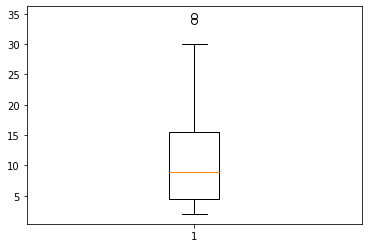

In [41]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['refactoring_perc_time_taken'])

In [42]:
main_df['actual_num_of_classes_touched_max'].mean()

10.193548387096774

In [43]:
len(main_df['actual_num_of_classes_touched_max'])

62

In [44]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 1000])

62

In [45]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 100])

62

In [46]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 50])

60

In [47]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 20])

54

In [48]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 10])

43

{'whiskers': [<matplotlib.lines.Line2D at 0x209c57d8e80>,
 'caps': [<matplotlib.lines.Line2D at 0x209c57e2588>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c57d8d30>],
 'medians': [<matplotlib.lines.Line2D at 0x209c57e2c88>],
 'fliers': [<matplotlib.lines.Line2D at 0x209c57e9048>],
 'means': []}

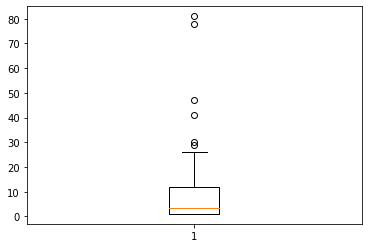

In [49]:
plt.boxplot(main_df['actual_num_of_classes_touched_max'])

In [50]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 1000]

{'whiskers': [<matplotlib.lines.Line2D at 0x209c583d748>,
 'caps': [<matplotlib.lines.Line2D at 0x209c583de10>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c583d5f8>],
 'medians': [<matplotlib.lines.Line2D at 0x209c58484e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x209c5848860>],
 'means': []}

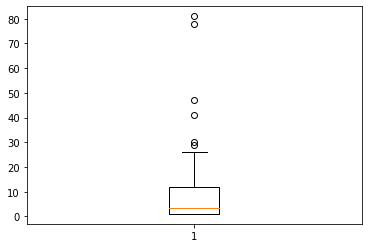

In [51]:
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

{'whiskers': [<matplotlib.lines.Line2D at 0x209c58a6908>,
 'caps': [<matplotlib.lines.Line2D at 0x209c58a6f60>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c58a67b8>],
 'medians': [<matplotlib.lines.Line2D at 0x209c58b36a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x209c58b3a20>],
 'means': []}

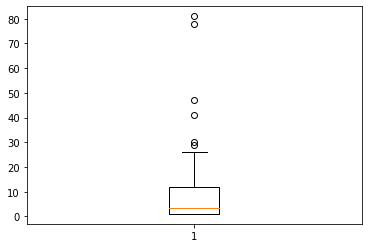

In [52]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 100]
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

In [53]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [54]:
pd_preds

,predict,actual_time_taken
0,14.707675,10.000000
1,7.788570,5.478927
2,16.580681,20.938326
3,19.316874,4.280046
4,10.824983,6.045198
5,10.358073,7.411236
6,17.443868,2.884615
7,19.029928,11.273423
8,7.123340,3.880597
9,8.273472,12.173913


{'whiskers': [<matplotlib.lines.Line2D at 0x209c5911e48>,
 'caps': [<matplotlib.lines.Line2D at 0x209c5920550>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c5911cf8>],
 'medians': [<matplotlib.lines.Line2D at 0x209c5920c50>],
 'fliers': [<matplotlib.lines.Line2D at 0x209c5920fd0>],
 'means': []}

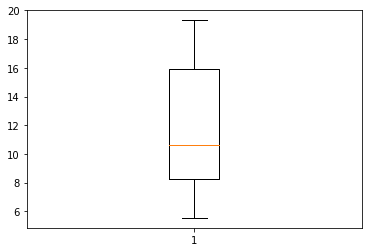

In [55]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x209c57618d0>,
 'caps': [<matplotlib.lines.Line2D at 0x209c57bf240>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c5761668>],
 'medians': [<matplotlib.lines.Line2D at 0x209c57af048>],
 'fliers': [<matplotlib.lines.Line2D at 0x209c57af400>],
 'means': []}

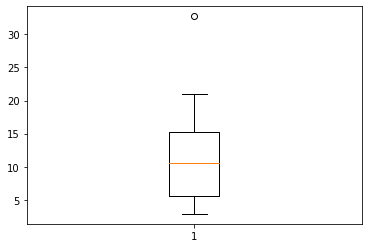

In [56]:
plt.boxplot(pd_preds['actual_time_taken'])

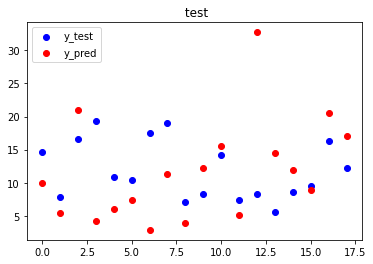

In [57]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],' test')

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

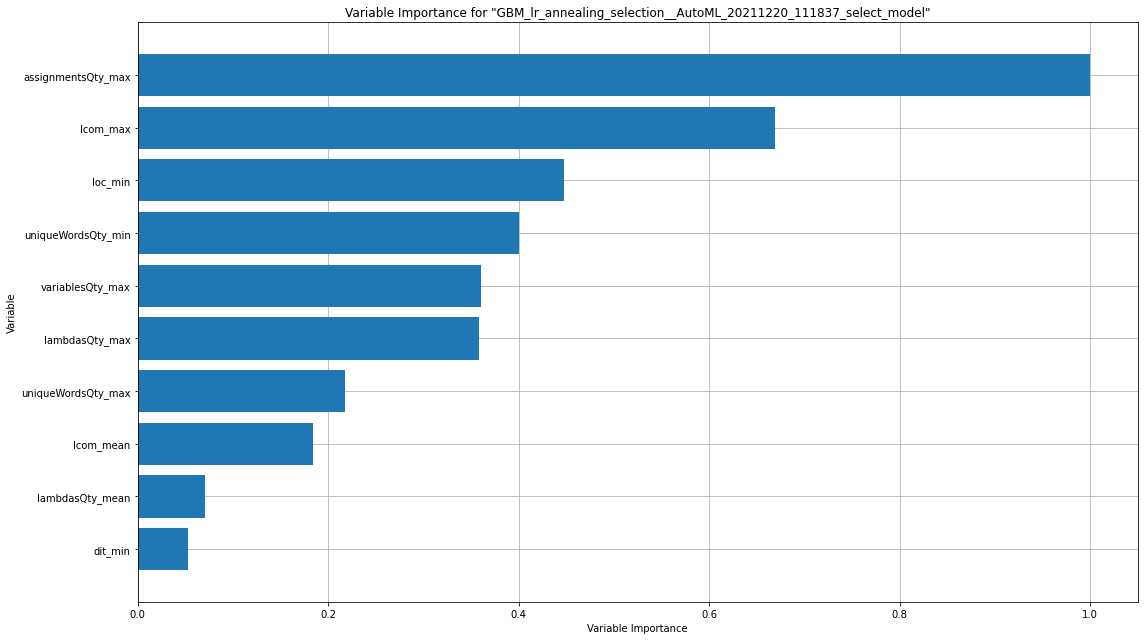

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

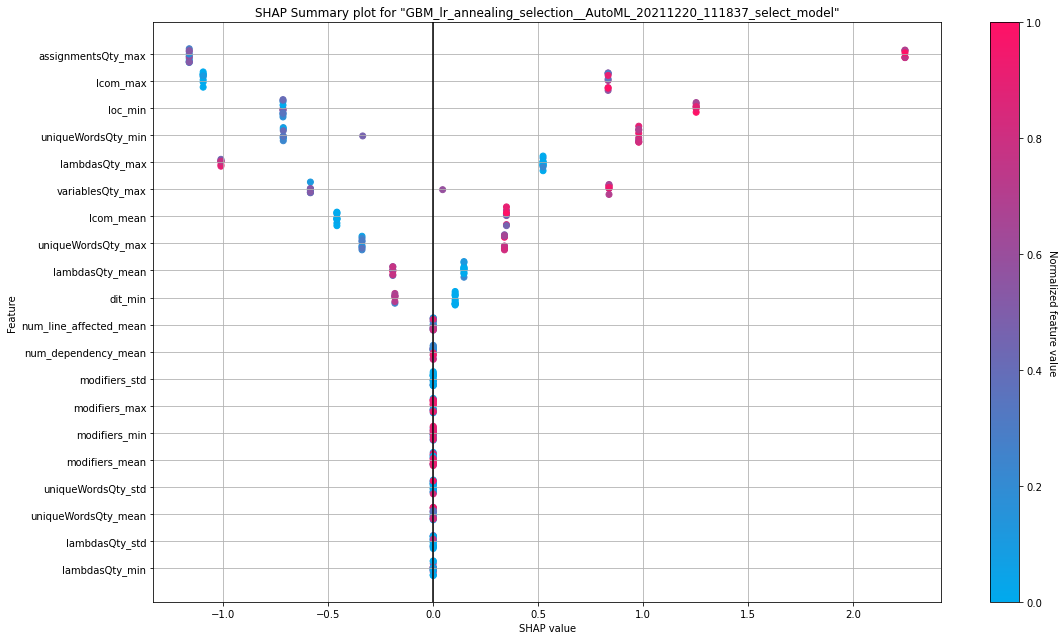

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

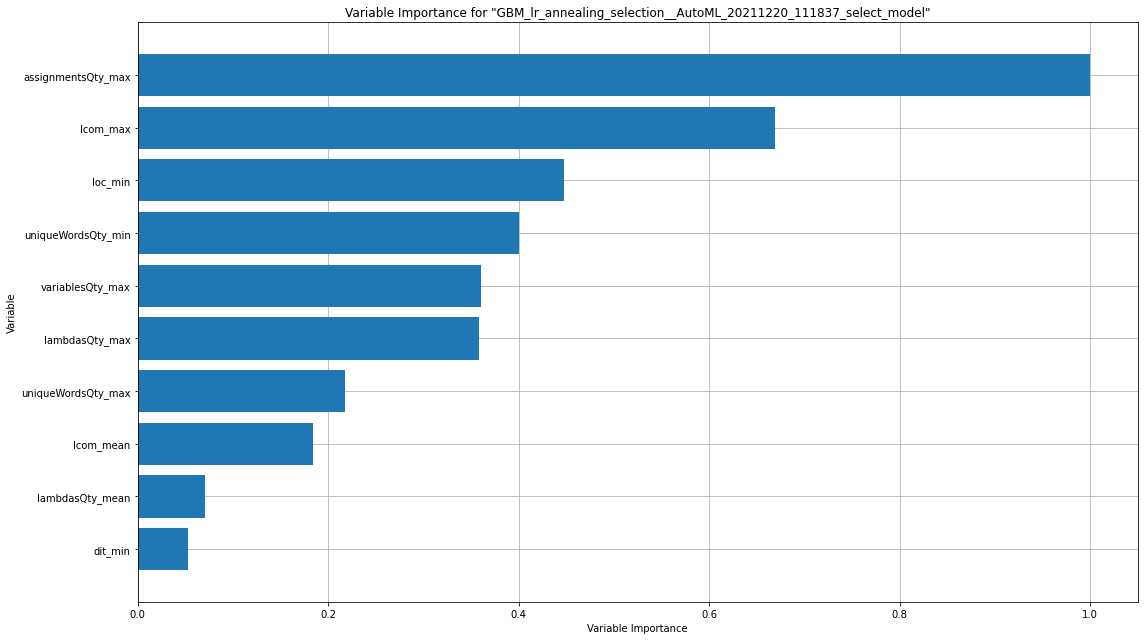

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

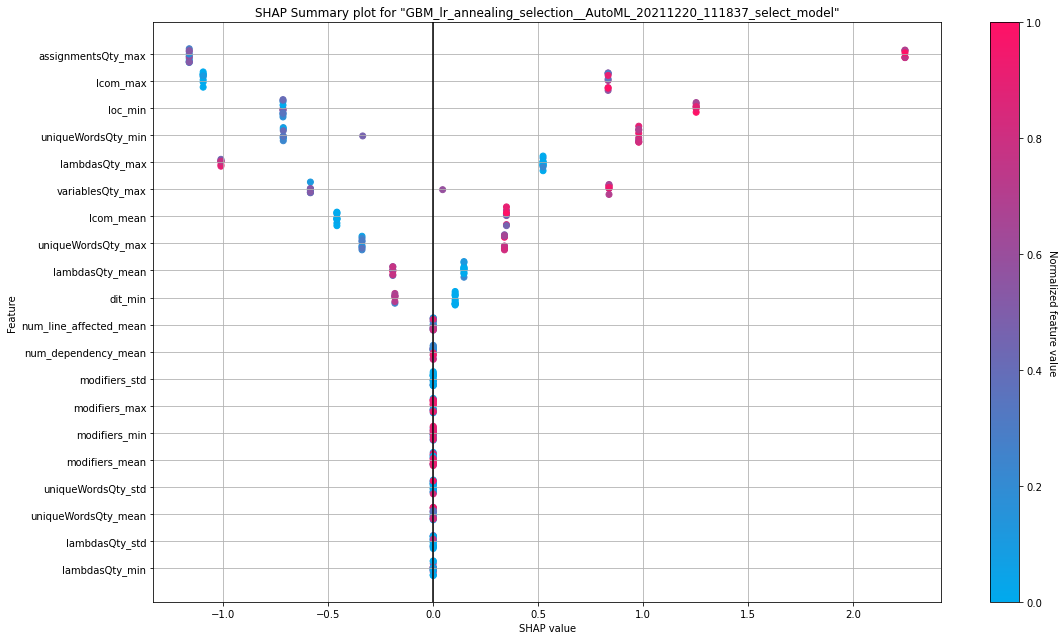

In [58]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [497]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

In [65]:
#aml.explain_row(test, row_index=0)

In [66]:
#h2o.shutdown()